# ROMMA Scraping again

Almost everyone knows that you can get time series by scraping pages.


https://www.infoclimat.fr/climatologie/normales-records/1981-2010/grenoble-lvd/valeurs/38538002.html

http://romma.fr/station_24.php?id=4&tempe=1

## Correlation between altitude and temperature

I actually did this after looking at the local data (see below).
The main problem was to get the correct page served. The data
is "hidden" behind a request like this

```/carte.php?dept=0&param=temperature&mobile=0&carteinterne=0```

but I kept getting a 403 error
when I asked for it using **get**. The problem was that I 
didn't set the User-Agent string correctly. After I copied 
it over from Chrome everything was easy.



## Local data

So I ended up doing averaging the data and doing some linear regression - 
all the variables:

- temperature
- humidity 
- solar radiation
- windiness

seem to be correlated.


In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import re
import time

import requests
import html

from scipy import stats

In [2]:
6*6

36

In [3]:
pp = re.compile('station_24\.php\?id=(\d+)"><b>(.*?),(.*?)m')
user_agent = {'User-agent': 'Mozilla/5.0'}

url = 'http://romma.fr/frame_station24.php'

r = requests.get('http://romma.fr', 
                 headers=user_agent)

stations = pp.findall(r.text)

In [4]:
code, name, alt = zip(*stations)
alt = [int(x) for x in alt]

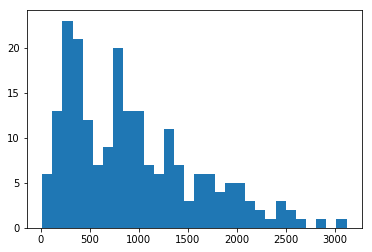

In [5]:
plt.hist(alt, bins=30);

In [ ]:
GET /carte.php?dept=0 HTTP/1.1
Host: www.romma.fr
Connection: keep-alive
Cache-Control: max-age=0
DNT: 1
Upgrade-Insecure-Requests: 1
User-Agent: Mozilla/5.0 (X11; CrOS x86_64 13597.15.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.22 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9
Sec-Fetch-Site: none
Sec-Fetch-Mode: navigate
Sec-Fetch-User: ?1
Sec-Fetch-Dest: document
Accept-Encoding: gzip, deflate, br
Accept-Language: en-IE,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,zh-CN;q=0.6,zh;q=0.5,en-US;q=0.4,nl;q=0.3
Cookie: rid=51Yg44; paramtab=0; ui-tabs-1=1


In [10]:
pr = re.compile('<tr>(.*?)</tr>', re.DOTALL)

url = r'https://www.romma.fr/carte.php?dept=0'

#https://stackoverflow.com/questions/38489386/python-requests-403-forbidden
user_agent = {'User-Agent': "Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36"}

params = {'dept' : 0}
params = {}
  
r = requests.get(url, 
                headers=user_agent,
                params=params)

fn = 'romma_{:.0f}.html'.format(time.time())
with open(fn,'w') as fp:
    fp.write(r.text)



{'Date': 'Sat, 12 Dec 2020 07:38:03 GMT', 'Server': 'Apache/2.4.38 (Debian)', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip', 'Content-Length': '28494', 'Content-Type': 'text/html; charset= ISO-8859-1', 'Set-Cookie': 'rid=51Yg44; expires=Fri, 08-Oct-2021 07:38:03 GMT; Max-Age=25920000', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive'}

In [12]:
r.text

'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="fr" lang="fr">\r\n<head>\r\n<title>R&eacute;seau d\'Observation M&eacute;t&eacute;o du Massif Alpin</title>\r\n <meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1" />\r\n <!--<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />-->\r\n<meta http-equiv="Content-Style-Type" content="text/css" />\r\n<meta http-equiv="Content-Language" content="fr" />\r\n<meta http-equiv="Pragma" content="no-cache">\r\n<meta http-equiv="X-UA-Compatible" content="IE=9; IE=8; IE=7; IE=EDGE" />\r\n<meta name="keywords" content="météo, meteo, meteo en france, météo alpes, meteo alpes, meteo haute savoie, météo haute savoie, météo savoie, meteo savoie, météo isere, météo isère, météo hautes alpes, meteo hautes alpes, neige, enneigement, prévision météo alpes, previsions meteo alpes, previsions meteo haute savoie

In [5]:
px = re.compile('overlib\((.*?)CAPTION,(.*?)\);',re.DOTALL)
tt = re.compile("class=\\\\'blanc\\\\'>(.*?)</td")
#tt = re.compile(r"<td class=>\'blanc\'</td>")

xxx = []
for k, ss in enumerate(px.findall(r.text)):
    if k  % 2: continue
    station_data, station_name = ss
    xxx.append( station_name + tt.findall(station_data)[0] )
    
xxx = ' '.join(xxx)


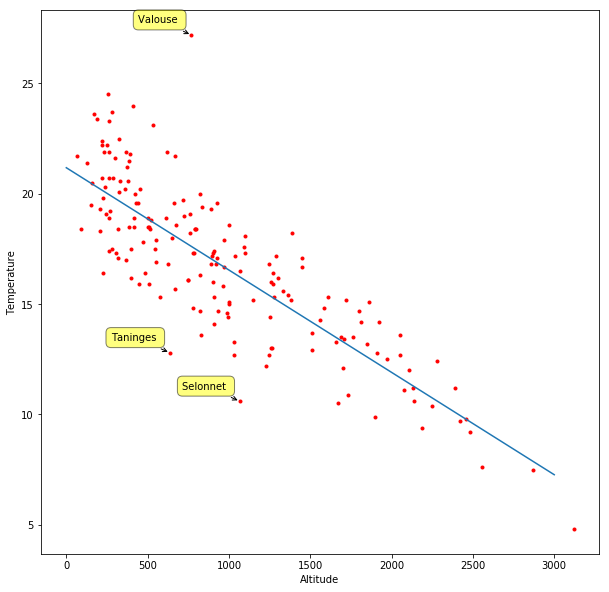

In [10]:
nps = re.compile("\'(.*?)\((\d+).*?>(.*?)<")
# drop anywhere that hasn't give a valid temperature
valid_pairs = [x for x in nps.findall(xxx) if '--' not in x[-1]]

#cast strings to numbers
N, A, T = list(zip(* valid_pairs ) )
A = np.array([int(x) for x in A])
T = np.array([float(x) for x in T])

fig, ax = plt.subplots()
fig.set_size_inches(10,10)

ax.plot(A,T,'r.') 

#I commented this out to see what it looked like 
#when I do the regression after taking outliers out.
#vv = stats.linregress(A,T)
X = np.array([0,3000])
ax.plot(X, vv.slope*X + vv.intercept)

#find the outliers
mask = abs((vv.slope*A + vv.intercept) - T) > 5

#label the outliers
labels = [x for x, y in zip(N, mask) if  y]

for label, x, y in zip(labels, A[mask], T[mask]):
    ax.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.xlabel('Altitude');
plt.ylabel('Temperature');

In [11]:
1/vv.slope, vv.rvalue

(-215.5975986349733, -0.868767449528063)

Let's redo the regression without the outliers

In [9]:
U = np.copy(T)
diff = (vv.slope*A + vv.intercept) - T
mask = abs(diff) > 4
U[mask] = (vv.slope*A[mask] + vv.intercept) 
vv = stats.linregress(A,U)
vv

LinregressResult(slope=-0.004638270585254025, intercept=21.179789106435905, rvalue=-0.868767449528063, pvalue=2.690456899975105e-55, stderr=0.0001998627831557276)

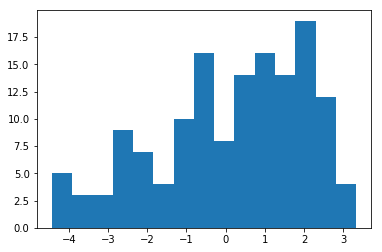

In [9]:
plt.hist((vv.slope*A[~mask] + vv.intercept) - T[~mask], bins= 15);

In [15]:
[x for x, y in zip(N, abs(diff) > 4) if y]

['Selonnet ',
 'St-Christophe/Guiers - Berland ',
 'Ambérieu-en-Bugey ',
 'Taninges ',
 'Saint-Laurent-du-Pont ',
 'Valouse ']

http://romma.fr/carte.php?dept=0&param=temperature&mobile=0&carteinterne=0


document.querySelector("#carte > div:nth-child(321)")
document.querySelector("#carte > div:nth-child(46)")
document.querySelector("#carte > div:nth-child(213)")


## Extracting the data arrays

The good stuff is hiden in a frame but is easily accesible

In [40]:
def html2arrays(txt):
    def val2float(x):
        if x == '':
            return float('nan')
        return float(x)

    #I was dumping this from chrome and it  imposes fixed line widths
    #txt = re.sub('=\n','',txt)

    #json style null->nan
    #because we are going to cast string to float later
    txt = re.sub('null', 'nan', txt)

    pp = re.compile( 'var ([\w|\s]*?)array=.*?\[(.*?)\]', re.DOTALL)
    mm = pp.findall(txt)

    data = dict(mm)
    data.keys()

    fields = ['time', 'temp', 'pluie', 'intenspluie', 
              'pression', 'hum', 'rad','rafale','vent','ventdir']
    arrays = {}
    for key in fields:
       
        try:
            arrays[key] = np.array( [ val2float(x) for x in data[key].split(',')])
        except:
            print(key)
            
        #continue
        
        #this fixes holes in the time series
        if key == 'time':
            index = (arrays[key] - arrays[key][0])/600000 
            index = index.astype(np.int32)
            index[index > 4463] = 4463 # just to be safe
   
        else:
            fix = np.zeros(4464)
            fix[index] = arrays[key]
            arrays[key] = fix
            
    return arrays
        
def get_station(ref_num=6):       
    url =  'https://www.romma.fr/frame_station24.php?id_station={}&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige='

    headers = {'User-Agent': "Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36",
             'Host': 'romma.fr',
            'Referer': 'https://www.romma.fr/station_24.php?id=4&tempe=1'}
    print(url)
    
    r = requests.post(url.format(ref_num) , 
                     headers=headers)
    
    return r.text


data = {}
for k in [3,5,109,44,4,6]: 
    tt = get_station(ref_num=k)
    meteo = html2arrays(tt)
    data[k] = meteo


https://www.romma.fr/frame_station24.php?id_station={}&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige=
https://www.romma.fr/frame_station24.php?id_station={}&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige=
https://www.romma.fr/frame_station24.php?id_station={}&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige=
https://www.romma.fr/frame_station24.php?id_station={}&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige=
https://www.romma.fr/frame_station24.php?id_station={}&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige=
https://www.romma.fr/frame_station24.php?id_station={}&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige=


In [36]:
url = 'https://www.romma.fr/frame_station24.php?id_station=3&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige='
headers = {'User-Agent': "Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36",
             'Host': 'romma.fr',
          'Referer': 'https://www.romma.fr/station_24.php?id=4&tempe=1'}

   
r = requests.post(url, 
                 headers=headers)


In [41]:
r

<Response [200]>

In [27]:
GET /frame_station24.php?id_station=4&tempe=1&humi=&pluie=&vent=&pressure=&rayonnement=&neige= HTTP/1.1
Host: www.romma.fr
Connection: keep-alive
Upgrade-Insecure-Requests: 1
DNT: 1
User-Agent: Mozilla/5.0 (X11; CrOS x86_64 13505.27.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.38 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9
Sec-Fetch-Site: same-origin
Sec-Fetch-Mode: navigate
Sec-Fetch-Dest: iframe
Referer: https://www.romma.fr/station_24.php?id=4&tempe=1
Accept-Encoding: gzip, deflate, br
Accept-Language: en-IE,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,zh-CN;q=0.6,zh;q=0.5,en-US;q=0.4,nl;q=0.3
Cookie: rid=51Yg44; paramtab=0; ui-tabs-1=1


b'<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<html><head>\n<title>404 Not Found</title>\n</head><body>\n<h1>Not Found</h1>\n<p>The requested URL was not found on this server.</p>\n<hr>\n<address>Apache/2.4.38 (Debian) Server at romma.fr Port 443</address>\n</body></html>\n'

Vizille = 5 seemed to be out of sync with the other sites

In [42]:
for k in [3,5,109,44,4,6]: 
    print(data[k]['time'][0])

1601964000000.0
1601964000000.0
1601964000000.0
1601964000000.0
1601964000000.0
1601964000000.0


In [155]:
(1592553600000.0 - 1592546400000.0) / 60000

120.0

In [43]:
import pickle

def hour(x):
    tt = time.localtime(x/1000)
    return tt.tm_hour + tt.tm_min/60
    
day = 24*6

# this is a bit risky it assumes there isn't a hole in the data
times = np.array([hour(x) for x in data[4]['time'][:day]])


# use pickle and not json as we have np.array
fn = '6nov.pkl'
data['times'] = times
with open(fn,'wb') as fp:
    pickle.dump(data,fp)

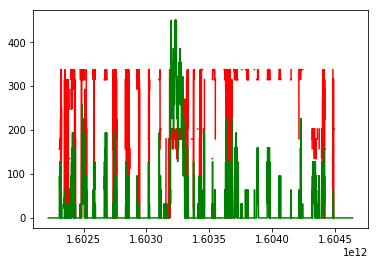

In [44]:
meteo = data[4]


ww = 28*24*6
plt.plot(meteo['time'][-ww:], meteo['ventdir'][-ww:],'r')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:]*20,'g')

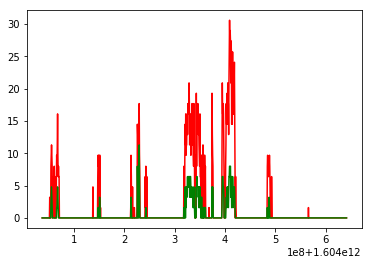

In [45]:
ww = 7*24*6
plt.plot(meteo['time'][-ww:], meteo['rafale'][-ww:],'r')
#plt.plot(tt[-ww:],np.diff(temp,n=1)[-ww:],'b')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:],'g')

    

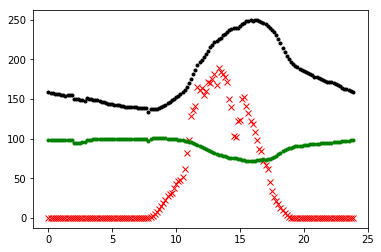

In [46]:

def tot(key='rad'):
    day = 24*6
    tot = np.zeros((day), dtype=np.float32)
    for k in range(31):
        tot += np.roll(meteo[key], k*day)[:day]
    return tot

    
# this is a bit risky it assumes there isn't a hole in the data
times = np.array([hour(x) for x in meteo['time'][:day]])


#plt.plot( times, tot(key='vent'),'b.')
plt.plot( times ,tot(key='rad')/50,'rx')
plt.plot( times ,tot(key='temp')/2,'k.')
plt.plot( times ,tot(key='hum')/28,'g.')

In [163]:
times = np.arange(144)/6


# There must be a better way

the function tot() kind of sucks  
- it's not very **numpy**.

what we really need is to 

1. reshape so that a row represents a day 
1. sum over the columns to get the average.

In [21]:
np.arange(12).reshape(3,4), np.sum(np.arange(12).reshape(3,4), axis=0)

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]), array([12, 15, 18, 21]))

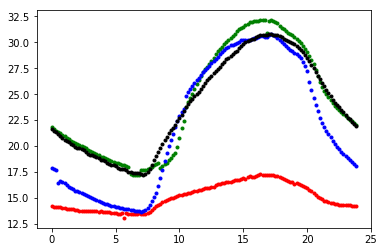

In [22]:
npts = 4464
ndays = npts//24//6

cols = [ x for x in 'rgbky']

for k in [3,4,5,6]:
    mm = data[k]['temp'].reshape(ndays, 24*6)/ndays
    #clean up the nan
    mm[np.isnan(mm)] = 0
    mm[mm>1000] = 0
    plt.plot(times, np.sum(mm, axis=0), cols.pop(0) + '.')

In [23]:
npts = 4464
ndays = npts//24//6


blacklist = ['time', 'pression', 
             'ventdir', 'pluie', 
             'intenspluie']

averages = {}

for station, series in data.items():
    #I stored the times as a field it's an ndarray not dict
    if station == 'times': continue
    tmp = {}
    for tag, xx in series.items():
        if tag in blacklist: continue
        mm = xx.reshape(ndays, 24*6)/ndays
        #clean up the nan
        mm[np.isnan(mm)] = 0
        #kill outliers in rad
        mm[mm>1000] = 0
        tmp[tag] = np.sum(mm, axis=0)
    averages[station] = tmp
     

## Let's show them all in a multiplot

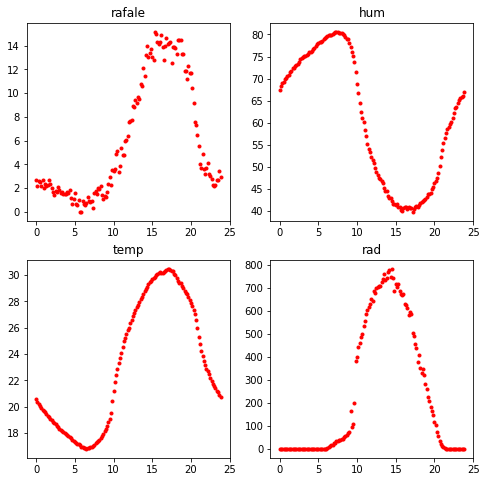

In [157]:
fig, axs = plt.subplots(2,2)
#[axi.set_axis_off() for axi in axs.ravel()]
fig.set_size_inches(8,8)

meteo = averages[4]

for k,tag in enumerate(['rafale','temp','hum','rad']):

    axs[k % 2 , k // 2].plot(times, meteo[tag],'r.')
    axs[k % 2 , k // 2].set_title(tag)
    

# Sunshine over a month

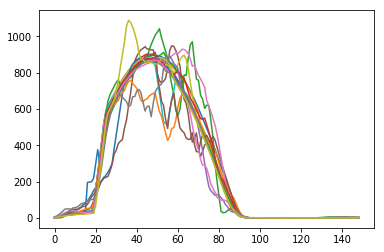

In [184]:
xx = np.copy(data[4]['rad'])
xx[xx > 2000] = 1000
xx = xx.reshape(31, len(xx)//31 )

for x in xx:
    if sum(x) < 35000: continue
    plt.plot(np.convolve(x,np.ones(6))/6 )

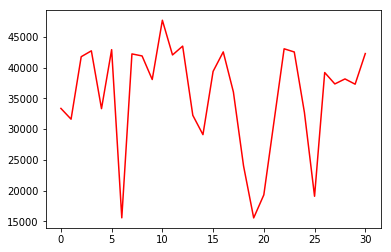

In [191]:
plt.plot([sum(x) for x in xx],'r-')

## Humidity and temperature

they seem to be correlated so let's do a linear regression to see if that is actually the case.

There might be **nan**s in the arrays so mask them out before doing the regression.

In [192]:
from scipy import stats

cors = {}
for k in [3,4,5,6,109]:
    x = data[k]
    X = np.sum( x['temp'].reshape(ndays, 24*6)/ndays, axis=0)
    Y = np.sum( x['hum'].reshape(ndays, 24*6)/ndays, axis=0)

    mask = ~(np.isnan(X) | np.isnan(Y))
    cors[k] = stats.linregress( X[mask], Y[mask])

In [193]:
cors

{3: LinregressResult(slope=-0.19110208104744422, intercept=77.13673974184037, rvalue=-0.21444092960366498, pvalue=0.010116405778747018, stderr=0.0733036838367571),
 4: LinregressResult(slope=-3.0097099747342506, intercept=130.54678025904084, rvalue=-0.9973370898886585, pvalue=2.2831382853717435e-163, stderr=0.01846896005041522),
 5: LinregressResult(slope=-3.028282245204879, intercept=134.84021286633964, rvalue=-0.993976627063515, pvalue=2.9947835834283367e-138, stderr=0.028019211801428624),
 6: LinregressResult(slope=-3.3110073718837683, intercept=137.2393557999482, rvalue=-0.9969033456491834, pvalue=1.0117975331182666e-158, stderr=0.021917338258521518),
 109: LinregressResult(slope=-2.7249459297370366, intercept=121.19107074344143, rvalue=-0.9779881901843425, pvalue=3.6240069850456903e-97, stderr=0.04913602090582902)}

### Retiming

I have to plot the data against time otherwise it's offset
so that midnight is no longer at zero.

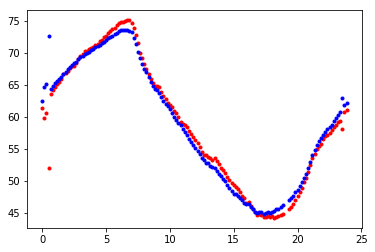

In [225]:
k = 109

vv = cors[k]
a, b = vv.slope, vv.intercept

x = data[k]
X = np.sum( x['temp'].reshape(ndays, 24*6)/ndays, axis=0)
Y = np.sum( x['hum'].reshape(ndays, 24*6)/ndays, axis=0)

plt.plot(times,Y,'r.')
#plt.plot(times,X,'g.')
plt.plot(times, a*X + b, 'b.')

## Finally calculate the time of max temperature

I checked this by hand it seems to be pretty accurate
but there is a bug with multiple days

In [586]:
time_tics = data[3]['time']

TS = data[109]['temp']

numdays = 30
ts = [i for i in range(-1,-1 - numdays*24*6, -24*6)]

#use smh as a reference the others don't seem reliable
day_intervals = [list(zip( TS, time_tics))[i:j] 
                                       for i,j in  zip(ts[1:],ts)]
mx = [max(day) for day in day_intervals if day]
x,y = zip(*mx)
[time.ctime(t/1000.)[4:16] for t in y]

['Jul 21 16:20',
 'Jul 20 18:00',
 'Jul 20 14:50',
 'Jul 19 15:10',
 'Jul 18 15:10',
 'Jul 16 18:20',
 'Jul 15 16:40',
 'Jul 14 17:40',
 'Jul 13 16:50',
 'Jul 12 16:50',
 'Jul 12 15:10',
 'Jul 10 17:20',
 'Jul  9 18:40',
 'Jul  9 15:10',
 'Jul  8 15:10',
 'Jul  6 16:40',
 'Jul  5 18:40',
 'Jul  5 15:10',
 'Jul  4 15:00',
 'Jul  2 16:50',
 'Jul  1 15:50',
 'Jul  1 15:00',
 'Jun 29 17:30',
 'Jun 28 17:30',
 'Jun 27 17:10',
 'Jun 27 15:00',
 'Jun 25 17:20',
 'Jun 24 18:20',
 'Jun 24 15:10']

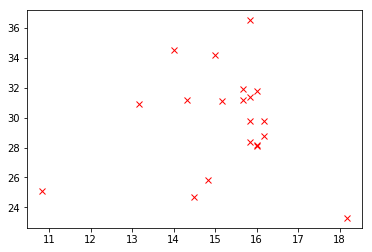

In [76]:
XS, YS = zip(*mx)
YS = [(int(y)//1000 % (24*3600)) /3600 for y in YS]
plt.plot(YS,XS, 'rx')

## Calculate the length of a day

In [209]:
for k, y in averages.items():
    if max(y['rad']) == 0: continue
    day_light = times[y['rad'] > 4]
    print(k, max(day_light), min(day_light) )

3 21.333333333333332 6.0
5 21.333333333333332 6.166666666666667
109 21.166666666666668 6.0
4 21.333333333333332 6.166666666666667
6 21.333333333333332 6.166666666666667


In [208]:
min(averages[44]['rad'])

0.0

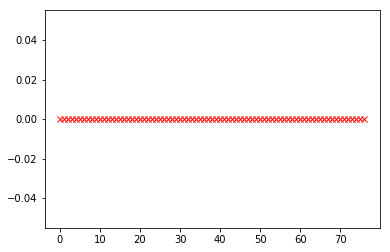

In [126]:
trans = [int(y)//1000 % (24*3600) /3600 for y in night]
trans = [ min(x,8) for x in trans ]

plt.plot(range(len(trans)),trans,'rx')

In [516]:
! ./.g


[master 300c919] web
 2 files changed, 165 insertions(+), 101 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 30.53 KiB | 976.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/macbuse/ROMMA.git
   991f4c4..300c919  master -> master


In [111]:
4464 - 4455

9

In [115]:
tt = get_station(ref_num=109)
meteo = html2arrays(tt)
len(meteo['time'])

4455

In [135]:
index = (meteo['time'] - meteo['time'][0])/600000 
index = index.astype(np.int32)

In [139]:
uu = np.diff(index)
sum( uu[uu > min(uu)] - min(uu) )

9

In [128]:
4464 // 24 //6

31

In [188]:
! ./.g

[master e64405b] web
 2 files changed, 18 insertions(+), 18 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 484 bytes | 121.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/macbuse/ROMMA.git
   a388f89..e64405b  master -> master


In [187]:
!pwd


/home/gregmcshane/ROMMA
